# EDA Step 2 - DATA CLEANSING

## Uploading Pickle File from EDA Step 1

In [215]:
import matplotlib as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import pickle
from scipy.stats import zscore, ks_2samp

#pulling Flat File PKL format

pickle_file = 'tmdb_EDA_data_protocol_file.pkl'

#Read a pickle file and load the data
with open(pickle_file, 'rb') as file:
    loaded_data = pickle.load(file)

print(type(loaded_data))

if not isinstance(loaded_data, pd.DataFrame):
    print('Problem with desrielizing TMDB Pickle file')
else: 
    df = loaded_data.copy()

<class 'pandas.core.frame.DataFrame'>


In [216]:
#check df shape
df.shape

(71370, 38)

In [217]:
#check df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         71370 non-null  int64         
 1   name                       71370 non-null  string        
 2   number_of_seasons          71370 non-null  int64         
 3   number_of_episodes         71370 non-null  int64         
 4   original_language          71370 non-null  category      
 5   vote_count                 71370 non-null  int64         
 6   vote_average               71370 non-null  float64       
 7   adult                      71370 non-null  category      
 8   first_air_date             71370 non-null  datetime64[ns]
 9   last_air_date              70664 non-null  datetime64[ns]
 10  in_production              71370 non-null  category      
 11  popularity                 71370 non-null  float64       
 12  type

# A) Visualize Numerical Features via Boxplot

In [218]:
df_numerical = df.select_dtypes(include=['int64','float64'])
df_numerical = df_numerical.drop('id', axis = 1)
numeric_cols = df_numerical.columns
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number_of_seasons         71370 non-null  int64  
 1   number_of_episodes        71370 non-null  int64  
 2   vote_count                71370 non-null  int64  
 3   vote_average              71370 non-null  float64
 4   popularity                71370 non-null  float64
 5   episode_run_time          71370 non-null  int64  
 6   num_production_companies  71370 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 3.8 MB


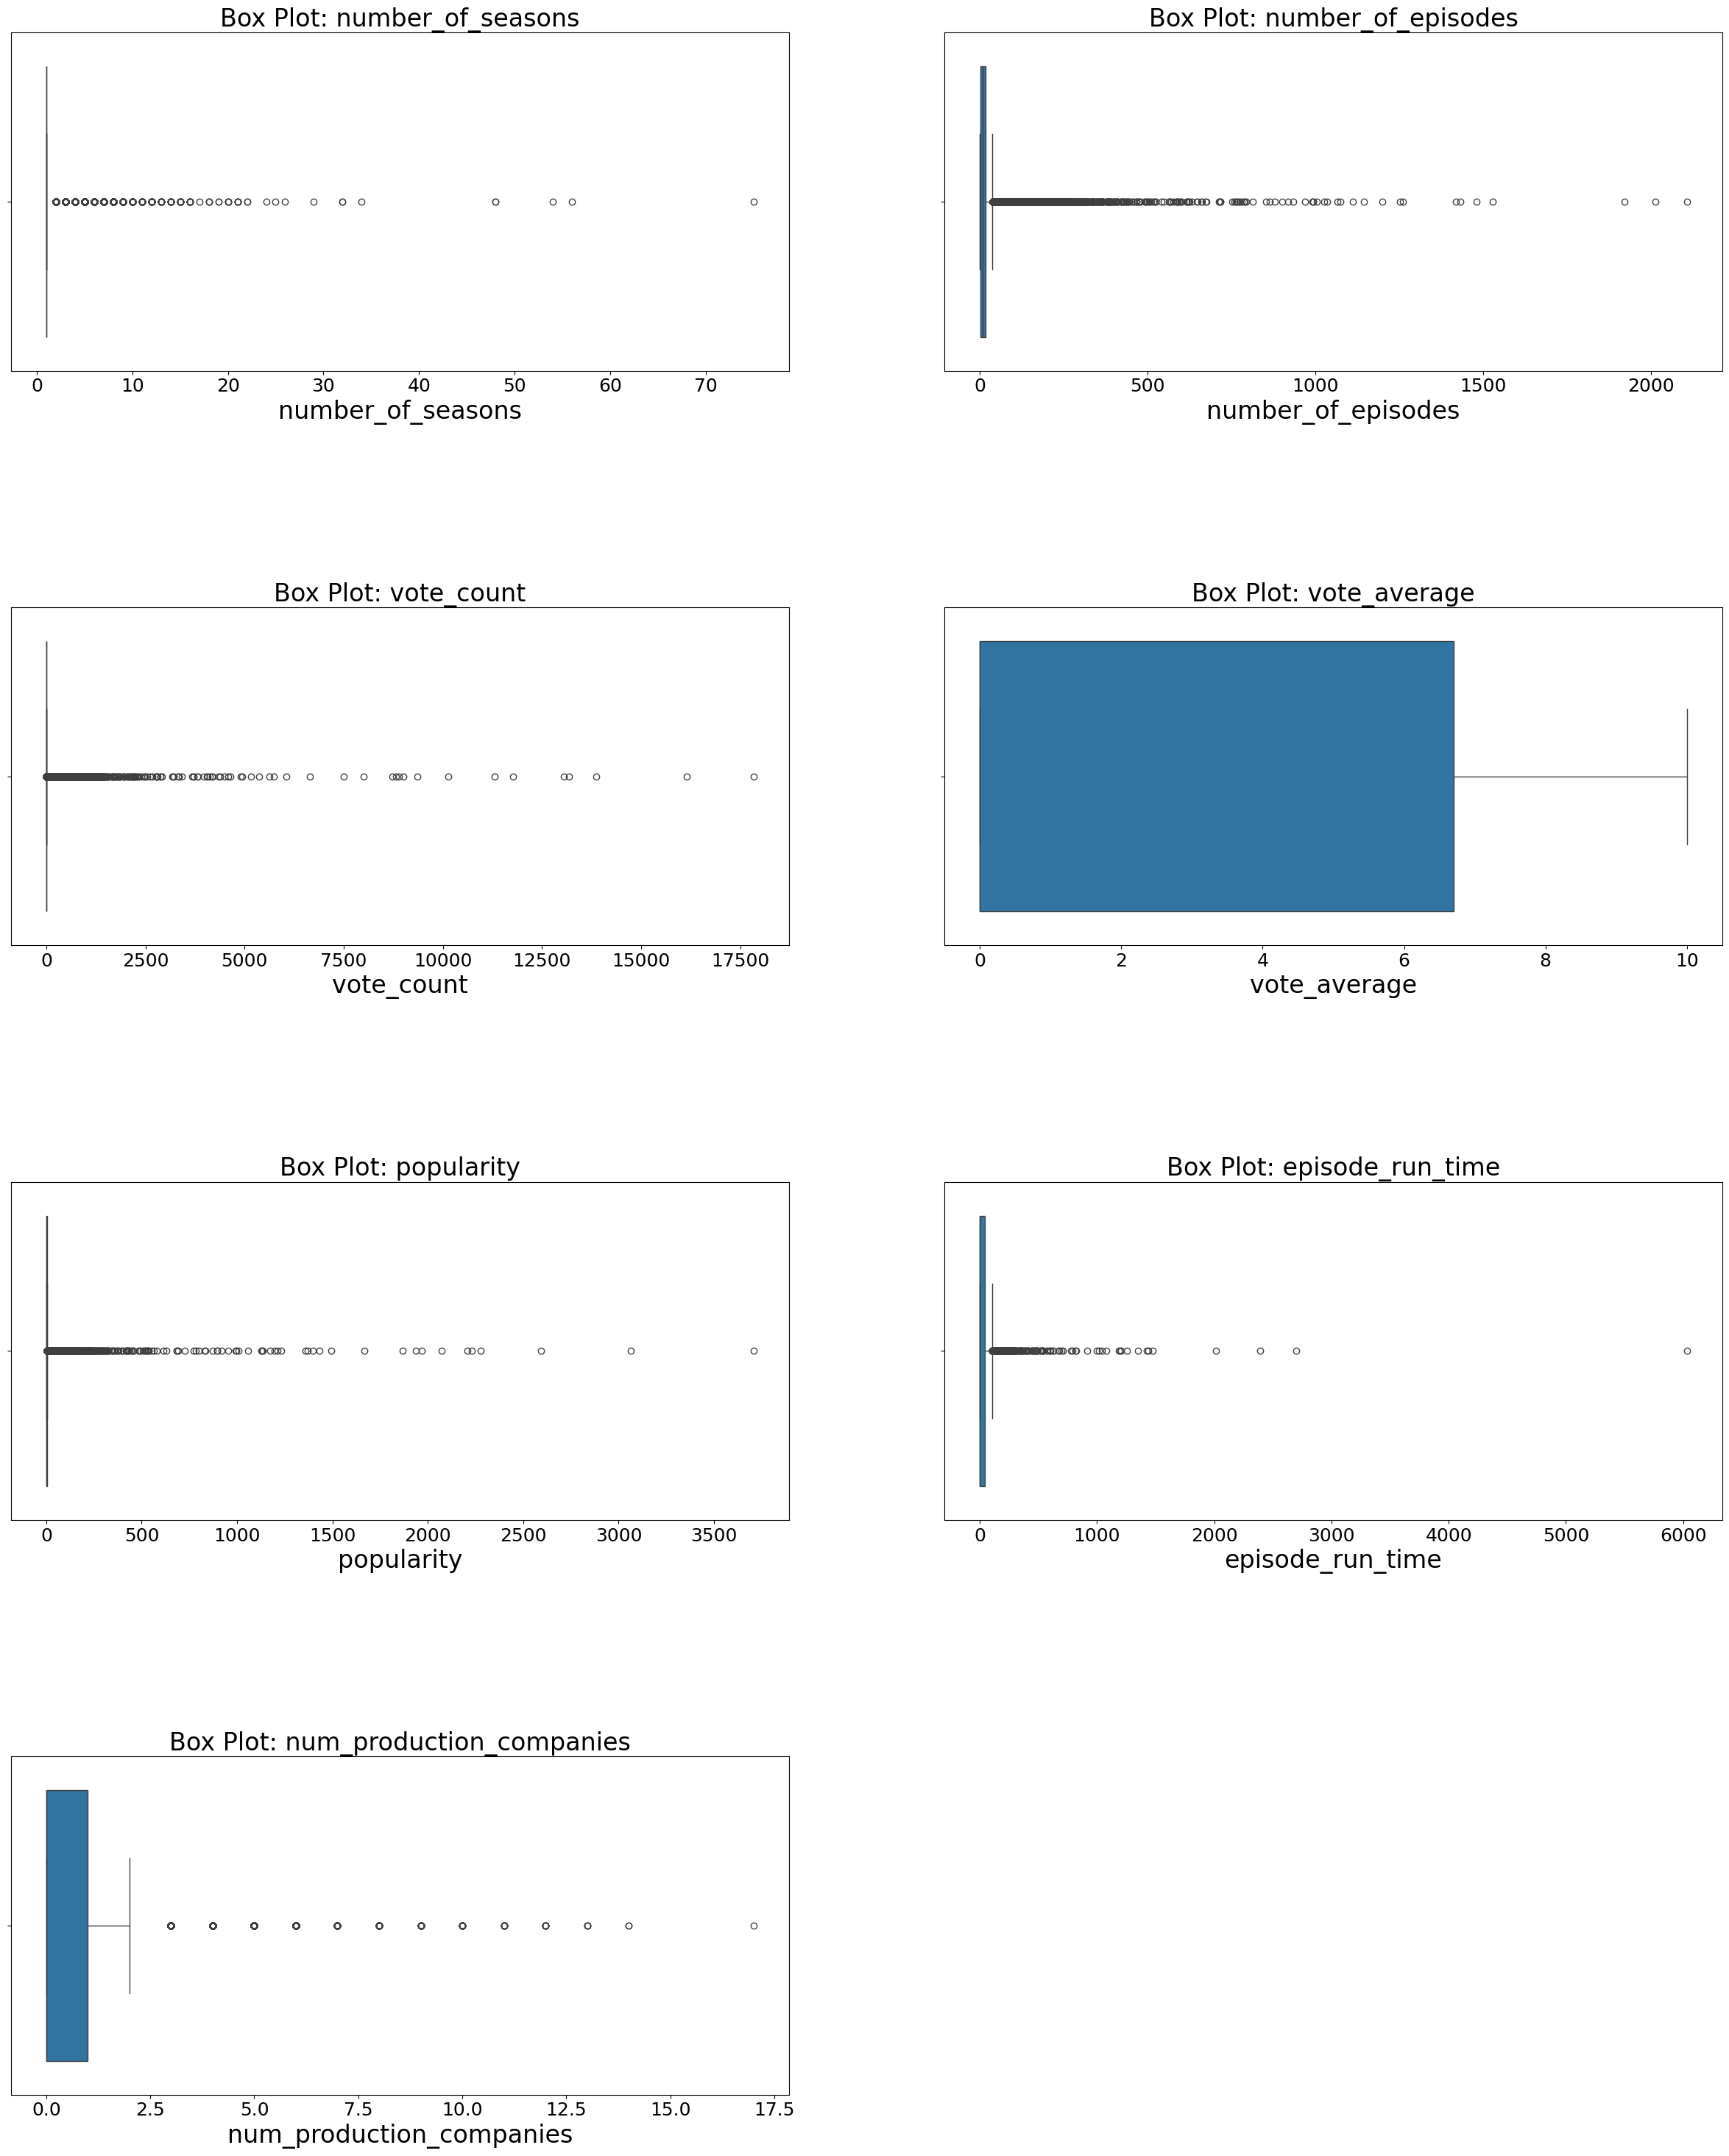

In [219]:
import matplotlib.pyplot as plt

def outliers_boxplot(temp_df):
    plt.figure(figsize=(30, 300))
    for i, col in enumerate(numeric_cols):
        ax = plt.subplot(30, 2, i + 1)
        sb.boxplot(data=df_numerical, x=col, ax=ax)
        plt.title(f'Box Plot: {col}', fontsize=24)
        plt.xlabel(f'{col}', fontsize=24)
        plt.xticks(fontsize=18)
    plt.subplots_adjust(hspace=0.7)
    plt.show()

outliers_boxplot(df_numerical)

# B) Finding outliers. 

### Since all numerical attributes are right skewed and their distribution is not normal we will use the IQR test

In [220]:
# Function to identify and treat outliers using IQR
def outliers_df_A(temp_df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in numeric_cols:  # Ensure processing numeric columns only
        temp = pd.DataFrame(temp_df[col])
        Q1 = temp_df[col].quantile(0.25)
        Q3 = temp_df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(temp_df) * 100]
  
    return total_outliers[total_outliers['Percent'] >= 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = outliers_df_A(df_numerical).sort_values('Percent', ascending=False)
outliers_df

,Outlier count,Percent
vote_count,13271.0,18.594648
number_of_seasons,13105.0,18.362057
popularity,9697.0,13.586941
number_of_episodes,7129.0,9.988791
num_production_companies,3322.0,4.654617
episode_run_time,1055.0,1.478212
vote_average,0.0,0.000000


## Outlier count: The number of outliers in each column.
## Percent: The percentage of outliers in each column.

In [221]:
# Function to identify and treat outliers using IQR
def treat_outliers(temp_df, features):
    df_outliers = pd.DataFrame(index=temp_df.index)
    for feature in features:
        Q1 = temp_df[feature].quantile(0.25)
        Q3 = temp_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((temp_df[feature] < lower_bound) | (temp_df[feature] > upper_bound)).astype(int)
    return df_outliers

In [222]:
# Apply the outlier treatment function to numeric columns
outliers_df = treat_outliers(df, numeric_cols)
outliers_df

,number_of_seasons,number_of_episodes,vote_count,vote_average,popularity,episode_run_time,num_production_companies
0,1,1,1,0,1,0,0
1,1,0,1,0,1,0,0
2,1,1,1,0,1,0,1
3,1,1,1,0,1,0,1
4,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...
71365,0,0,0,0,0,0,0
71366,0,0,0,0,0,0,0
71367,0,0,0,0,0,0,0
71368,0,0,0,0,0,0,0


In [223]:
#Creating a table for outliers change
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed


In [224]:
for col in numeric_cols:
    out = df[col]
    non_out = df[col][outliers_df[col] == 0]
    cor_out = df['popularity']
    cor_non_out = df['popularity'][outliers_df[col] == 0]
    
    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)
    
    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] - 
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'

    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [outliers_df[col].sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})

    out_df = pd.concat([out_df, new_row], ignore_index=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [225]:
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed
0,number_of_seasons,13105,+,-
1,number_of_episodes,7129,+,+
2,vote_count,13271,+,+
3,vote_average,0,-,-
4,popularity,9697,+,-
5,episode_run_time,1055,+,-
6,num_production_companies,3322,+,-


## Filter features where only distribution changes but not correlation (disregard Target Feature - 'popularity')

In [226]:
out_df = out_df[out_df['feature'] != 'popularity']
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')
to_drop = out_df[out_df['drop'] == 'yes']['feature']
out_df

/var/folders/9s/4th6z41n21323fg950zg3xf40000gn/T/ipykernel_82844/3752191424.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')


,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,number_of_seasons,13105,+,-,yes
1,number_of_episodes,7129,+,+,no
2,vote_count,13271,+,+,no
3,vote_average,0,-,-,no
5,episode_run_time,1055,+,-,yes
6,num_production_companies,3322,+,-,yes


In [227]:
to_drop

0           number_of_seasons
5            episode_run_time
6    num_production_companies
Name: feature, dtype: object

In [228]:
# Remove outliers
df_cleaned = df.copy()
for col in to_drop:
    df_cleaned.loc[outliers_df[col] == 1, col] = np.nan

In [229]:
# Save cleaned data
df_cleaned.to_pickle('df_cleaned.pkl')
df_cleaned.to_csv('TMDB_df_clean.csv',index=False)

# Missing Values Imputation

## Start by checking how many missing values you have

In [230]:
# Function to calculate amount of missing values
def missing_values(df_temp):
    # Calculate number of missing values and percentage of missing values
    missing_data = df_temp.isnull().sum()
    missing_percentage = (df_temp.isnull().sum() / len(df_temp)) * 100

    # Combine into a DataFrame and filter columns with missing values
    missing_summary = pd.DataFrame({
        'Missing Values': missing_data,
        'Percentage': missing_percentage
    })
    # Display only columns with missing values
    missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

    return missing_summary

# Display the summary
missing_table = missing_values(df_cleaned)

missing_table

,Missing Values,Percentage
number_of_seasons,13105,18.362057
last_air_date,706,0.989211
episode_run_time,1055,1.478212
num_production_companies,3322,4.654617
origin_continent,10395,14.564943


In [231]:
#Imputing 'last_air_date' column with last day of the year (31/12/2024) as it appears from 
#analysis that all NULL dates are associated with TV_shows from 2023

# Define the last day of the year 2024
last_day_2024 = pd.Timestamp('2024-12-31')

# Replace None values in the 'last_air_date' column with the last day of 2024
df_cleaned['last_air_date'] = df_cleaned['last_air_date'].fillna(last_day_2024)


In [232]:
#Imputing 'origin_continent' column with 'Other' continenet
df_cleaned['origin_continent'] = df_cleaned['origin_continent'].cat.add_categories('Other')
df_cleaned['origin_continent'] = df_cleaned['origin_continent'].fillna('Other')

## Implement MICE

### To run MICE imputer we need to remove 'string' column and convert all categorical columns to codes (either use one-hot encoding or label-encoding)

In [233]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         71370 non-null  int64         
 1   name                       71370 non-null  string        
 2   number_of_seasons          58265 non-null  float64       
 3   number_of_episodes         71370 non-null  int64         
 4   original_language          71370 non-null  category      
 5   vote_count                 71370 non-null  int64         
 6   vote_average               71370 non-null  float64       
 7   adult                      71370 non-null  category      
 8   first_air_date             71370 non-null  datetime64[ns]
 9   last_air_date              71370 non-null  datetime64[ns]
 10  in_production              71370 non-null  category      
 11  popularity                 71370 non-null  float64       
 12  type

In [234]:
from sklearn.preprocessing import LabelEncoder

#remove 'string' column == > 'name' and two date columns  
df_cleaned = df_cleaned.drop('name', axis = 1)
df_cleaned = df_cleaned.drop('first_air_date', axis = 1)
df_cleaned = df_cleaned.drop('last_air_date', axis = 1)  

#simple conversion
# Convert the 'adult' column from boolean (True/False) to integers (1/0)
df_cleaned['adult'] = df_cleaned['adult'].astype(int)
df_cleaned['in_production'] = df_cleaned['in_production'].astype(int)
df_cleaned['genres_Documentary'] = df_cleaned['genres_Documentary'].astype(int) 
df_cleaned['genres_Musical'] = df_cleaned['genres_Musical'].astype(int)
df_cleaned['genres_Soap'] = df_cleaned['genres_Soap'].astype(int)
df_cleaned['genres_Sci-Fi & Fantasy'] = df_cleaned['genres_Sci-Fi & Fantasy'].astype(int)
df_cleaned['genres_Mystery'] = df_cleaned['genres_Mystery'].astype(int)
df_cleaned['genres_Romance'] = df_cleaned['genres_Romance'].astype(int)
df_cleaned['genres_Action & Adventure'] = df_cleaned['genres_Action & Adventure'].astype(int)
df_cleaned['genres_Drama'] = df_cleaned['genres_Drama'].astype(int)
df_cleaned['genres_War & Politics'] = df_cleaned['genres_War & Politics'].astype(int)
df_cleaned['genres_Empty'] = df_cleaned['genres_Empty'].astype(int)
df_cleaned['genres_Talk'] = df_cleaned['genres_Talk'].astype(int)
df_cleaned['genres_Western'] = df_cleaned['genres_Western'].astype(int)          
df_cleaned['genres_Crime'] = df_cleaned['genres_Crime'].astype(int)
df_cleaned['genres_Comedy'] = df_cleaned['genres_Comedy'].astype(int)
df_cleaned['genres_Reality'] = df_cleaned['genres_Reality'].astype(int)
df_cleaned['genres_Animation'] = df_cleaned['genres_Animation'].astype(int)          
df_cleaned['genres_Kids'] = df_cleaned['genres_Kids'].astype(int)
df_cleaned['genres_Family'] = df_cleaned['genres_Family'].astype(int)
df_cleaned['genres_News'] = df_cleaned['genres_News'].astype(int)
df_cleaned['genres_History'] = df_cleaned['genres_History'].astype(int)

#columns to convrt to one-hot encoding
one_hot_columns = ['type','status','networks', 'original_language', 'origin_continent']

# Step 1: Save a copy of the original DataFrame
df_original = df_cleaned.copy()

# Step 2: Perform One-Hot Encoding on the specified columns
df_clean_encoded = pd.get_dummies(df_cleaned, columns=one_hot_columns, prefix=one_hot_columns)

# Display the first few rows of the original and encoded DataFrames (optional)
print("Original DataFrame:")
print(df_cleaned.head())

print("\nOne-Hot Encoded DataFrame:")
print(df_clean_encoded.head())

Original DataFrame:
      id  number_of_seasons  number_of_episodes original_language  vote_count  \
0  71446                NaN                  41                es       17836   
1  66732                NaN                  34                en       16161   
2  63174                NaN                  93                en       13870   
3  69050                NaN                 137                en       13180   
4  93405                NaN                   9                ko       13053   

   vote_average  adult  in_production  popularity      type  ...  \
0         8.257      0              0      96.354  Scripted  ...   
1         8.624      0              1     185.711  Scripted  ...   
2         8.486      0              0     416.668  Scripted  ...   
3         8.479      0              0     143.750  Scripted  ...   
4         7.831      0              1     115.587  Scripted  ...   

  genres_Musical genres_Sci-Fi & Fantasy  genres_Mystery  genres_History  \
0       

In [235]:
df_clean_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Columns: 111 entries, id to origin_continent_Other
dtypes: bool(81), float64(5), int64(25)
memory usage: 21.8 MB


In [236]:
# Display the summary
missing_table = missing_values(df_clean_encoded)

missing_table

,Missing Values,Percentage
number_of_seasons,13105,18.362057
episode_run_time,1055,1.478212
num_production_companies,3322,4.654617


## Implementing MICE on all Numerical data (avoid last_air_date and origin_continent for now)

In [237]:
#!pip install fancyimpute
import fancyimpute 

In [238]:
# Using MICE to impute missing values
df_imputed = fancyimpute.IterativeImputer().fit_transform(df_clean_encoded)
df_imputed = pd.DataFrame(df_imputed, columns=df_clean_encoded.columns)

In [239]:
# Display the summary
missing_table = missing_values(df_imputed)

missing_table

,Missing Values,Percentage


In [240]:
df_imputed.head()

,id,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,in_production,popularity,episode_run_time,genres_Western,...,original_language_tr,original_language_ur,original_language_zh,origin_continent_Africa,origin_continent_Asia,origin_continent_Europe,origin_continent_North America,origin_continent_Oceania,origin_continent_South America,origin_continent_Other
0,71446.0,1.0,41.0,17836.0,8.257,0.0,0.0,96.354,70.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,66732.0,1.0,34.0,16161.0,8.624,0.0,1.0,185.711,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,63174.0,1.0,93.0,13870.0,8.486,0.0,0.0,416.668,45.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,69050.0,1.0,137.0,13180.0,8.479,0.0,0.0,143.750,45.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,93405.0,1.0,9.0,13053.0,7.831,0.0,1.0,115.587,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [246]:
##### indicate the missing points with one_zero 
df_clean_encoded_2 = df_clean_encoded.copy()

df_clean_encoded_2['number_of_seasons_na'] = 0
df_clean_encoded_2.loc[(df_clean_encoded_2['number_of_seasons'].isnull()),['number_of_seasons_na']] = 1

df_clean_encoded_2['episode_run_time_na'] = 0
df_clean_encoded_2.loc[(df_clean_encoded_2['episode_run_time'].isnull()),['episode_run_time_na']] = 1

df_clean_encoded_2['num_production_companies_na'] = 0
df_clean_encoded_2.loc[(df_clean_encoded_2['num_production_companies'].isnull()),['num_production_companies_na']] = 1

print(df_clean_encoded_2['number_of_seasons_na'].value_counts())
print(df_clean_encoded_2['episode_run_time_na'].value_counts())
print(df_clean_encoded_2['num_production_companies_na'].value_counts())

number_of_seasons_na
0    58265
1    13105
Name: count, dtype: int64
episode_run_time_na
0    70315
1     1055
Name: count, dtype: int64
num_production_companies_na
0    68048
1     3322
Name: count, dtype: int64


In [242]:
df_imputed = pd.concat([df_imputed,df_clean_encoded_2.iloc[:,111:]],axis=1)
df_imputed.head()

,id,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,in_production,popularity,episode_run_time,genres_Western,...,origin_continent_Africa,origin_continent_Asia,origin_continent_Europe,origin_continent_North America,origin_continent_Oceania,origin_continent_South America,origin_continent_Other,number_of_seasons_na,episode_run_time_na,num_production_companies_na
0,71446.0,1.0,41.0,17836.0,8.257,0.0,0.0,96.354,70.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0
1,66732.0,1.0,34.0,16161.0,8.624,0.0,1.0,185.711,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0
2,63174.0,1.0,93.0,13870.0,8.486,0.0,0.0,416.668,45.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,1
3,69050.0,1.0,137.0,13180.0,8.479,0.0,0.0,143.750,45.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,1
4,93405.0,1.0,9.0,13053.0,7.831,0.0,1.0,115.587,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0


<Axes: xlabel='None', ylabel='number_of_seasons'>

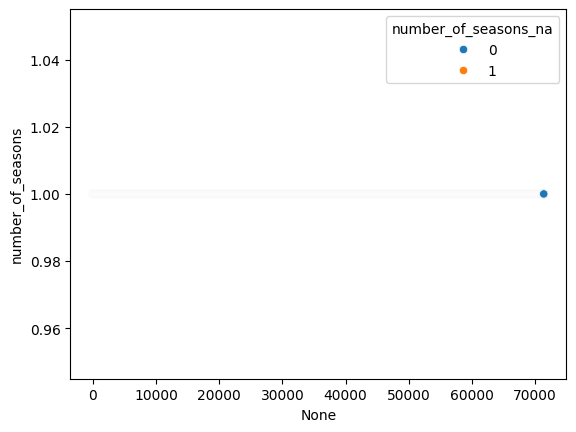

In [244]:
import seaborn as sns

sns.scatterplot(x=df_imputed.index,y=df_imputed['number_of_seasons'],hue=df_imputed['number_of_seasons_na'])

<Axes: xlabel='None', ylabel='episode_run_time'>

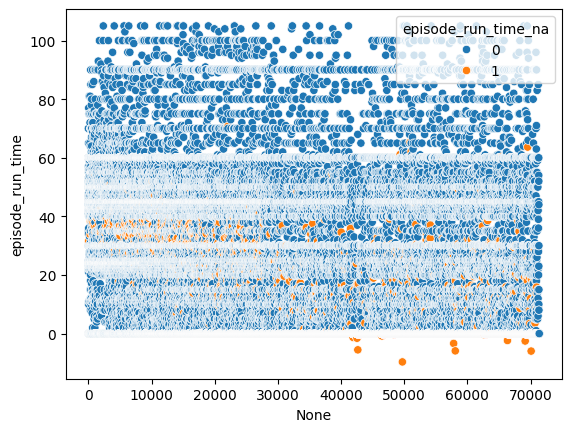

In [247]:
sns.scatterplot(x=df_imputed.index,y=df_imputed['episode_run_time'],hue=df_imputed['episode_run_time_na'])

<Axes: xlabel='None', ylabel='num_production_companies'>

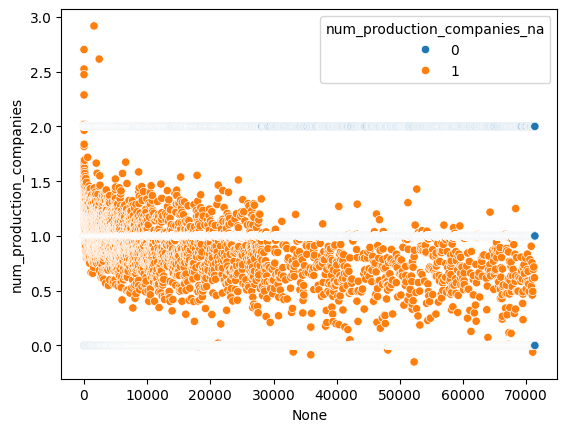

In [248]:
sns.scatterplot(x=df_imputed.index,y=df_imputed['num_production_companies'],hue=df_imputed['num_production_companies_na'])